In [1]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

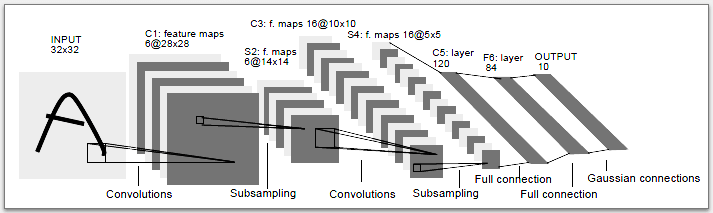

In [3]:
net = nn.Sequential(
    #BLOCO 1
    #(b,3,32,32) -> (b,6,28,28)
    nn.Conv2d(3,6,kernel_size=5), 
    nn.BatchNorm2d(6),
    nn.Tanh(),
    #(b,6,28,28) -> (b,6,14,14)
    nn.AvgPool2d(kernel_size=2),

    #BLOCO 2
    #(b,6,14,14) -> (b,16,10,10)
    nn.Conv2d(6,16,kernel_size=5), 
    nn.BatchNorm2d(16),
    nn.Tanh(),
    #(b,16,10,10) -> (b,16,5,5)
    nn.AvgPool2d(kernel_size=2),

    #BLOCO 3
    #(b,16,5,5) -> (b,120,1,1)
    nn.Conv2d(16,120,kernel_size=5), 
    nn.BatchNorm2d(120),
    nn.Tanh(),
    nn.Flatten(),

    #BLOCO 4
    #(b,n=120*1*1)
    nn.Linear(120,84),
    nn.Tanh(),
    nn.Linear(84,10)
).to(device)
net

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Tanh()
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Tanh()
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Tanh()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=120, out_features=84, bias=True)
  (13): Tanh()
  (14): Linear(in_features=84, out_features=10, bias=True)
)

# DADOS

In [4]:
train_set = datasets.CIFAR10(
    r'C:\Users\Usuario\Desktop\datasets_pytorch',
    train=True,
    transform=transforms.ToTensor(),
    download=False
)

test_set = datasets.CIFAR10(
    r'C:\Users\Usuario\Desktop\datasets_pytorch',
    train=False,
    transform=transforms.ToTensor(),
    download=False
)

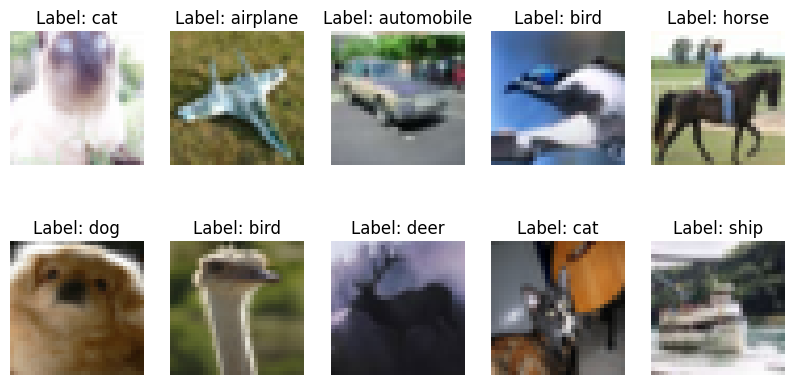

In [5]:
# Criar uma figura com 10 subplots
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # 2 linhas, 5 colunas

# Pegar 10 amostras aleatórias
for i, ax in enumerate(axes.flat):
    idx = torch.randint(len(train_set), size=(1,)).item()  # Índice aleatório
    image, label = train_set[idx]  # Obter imagem e label
    ax.imshow(image.permute(1, 2, 0))  # Converter formato (C, H, W) -> (H, W, C)
    ax.set_title(f"Label: {train_set.classes[label]}")  # Nome da classe
    ax.axis("off")  # Remover eixos

In [13]:
train_loader = DataLoader(
    train_set,
    batch_size=100,
    shuffle=True
)

test_loader = DataLoader(
    test_set,
    batch_size=50,
    shuffle=True
)

In [7]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(
    net.parameters(),
    lr=0.001,
    weight_decay=0.0005 
)

# TREINAMENTO

In [8]:
from sklearn.metrics import accuracy_score


In [9]:
def train(train_loader, net, epoch):
  # Training mode
  net.train()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(device)
    rotulo = rotulo.to(device)
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  print('#################### Train ####################')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100))
  
  return epoch_loss.mean()
    

In [ ]:
def validate(test_loader, net, epoch):
  # Evaluation mode
  net.eval()
    
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(device)
      rotulo = rotulo.to(device)

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = accuracy_score(pred_list, rotulo_list)
  
  print('********** Validate **********')
  print('Epoch %d, Loss: %.4f +/- %.4f, Acc: %.2f\n' % (epoch, epoch_loss.mean(), epoch_loss.std(), acc*100))
  
  return epoch_loss.mean()
    

In [14]:
train_losses, test_losses = [], []
for epoch in range(100):
  # Train
  train_losses.append(train(train_loader, net, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, net, epoch))

#################### Train ####################
Epoch 0, Loss: 1.5859 +/- 0.1191, Acc: 43.79
********** Validate **********
Epoch 0, Loss: 1.5747 +/- 0.1415, Acc: 43.77

#################### Train ####################
Epoch 1, Loss: 1.4054 +/- 0.1123, Acc: 49.97
********** Validate **********
Epoch 1, Loss: 1.4353 +/- 0.1576, Acc: 47.88

#################### Train ####################
Epoch 2, Loss: 1.3055 +/- 0.1074, Acc: 53.44
********** Validate **********
Epoch 2, Loss: 1.3184 +/- 0.1400, Acc: 52.78

#################### Train ####################
Epoch 3, Loss: 1.2363 +/- 0.1021, Acc: 55.96
********** Validate **********
Epoch 3, Loss: 1.2709 +/- 0.1579, Acc: 54.63

#################### Train ####################
Epoch 4, Loss: 1.1816 +/- 0.1070, Acc: 57.97
********** Validate **********
Epoch 4, Loss: 1.3162 +/- 0.1577, Acc: 53.71

#################### Train ####################
Epoch 5, Loss: 1.1345 +/- 0.1092, Acc: 59.69
********** Validate **********
Epoch 5, Loss: 1.1978 +/- 

KeyboardInterrupt: 

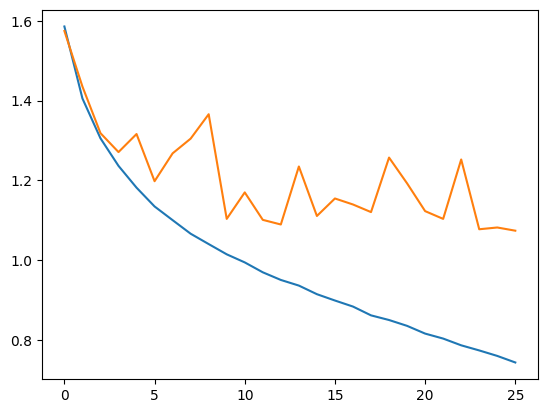

In [15]:
plt.plot(train_losses)
plt.plot(test_losses)